In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import SVG
from keras.utils import model_to_dot

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_image(image, cmap="binary"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

def show_model(model):
    display(SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))

Let's use FMNIST:

In [3]:
(X_trval, y_trval), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_trval = X_trval.astype(np.float32) / 255
X_test  = X_test.astype(np.float32) / 255

X_train, X_valid = X_trval[:-5000], X_trval[-5000:]
y_train, y_valid = y_trval[:-5000], y_trval[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
np.shape(X_train)

(55000, 28, 28)

In [5]:
np.random.randint(0,3,10)

array([2, 0, 2, 2, 0, 0, 2, 1, 2, 2])

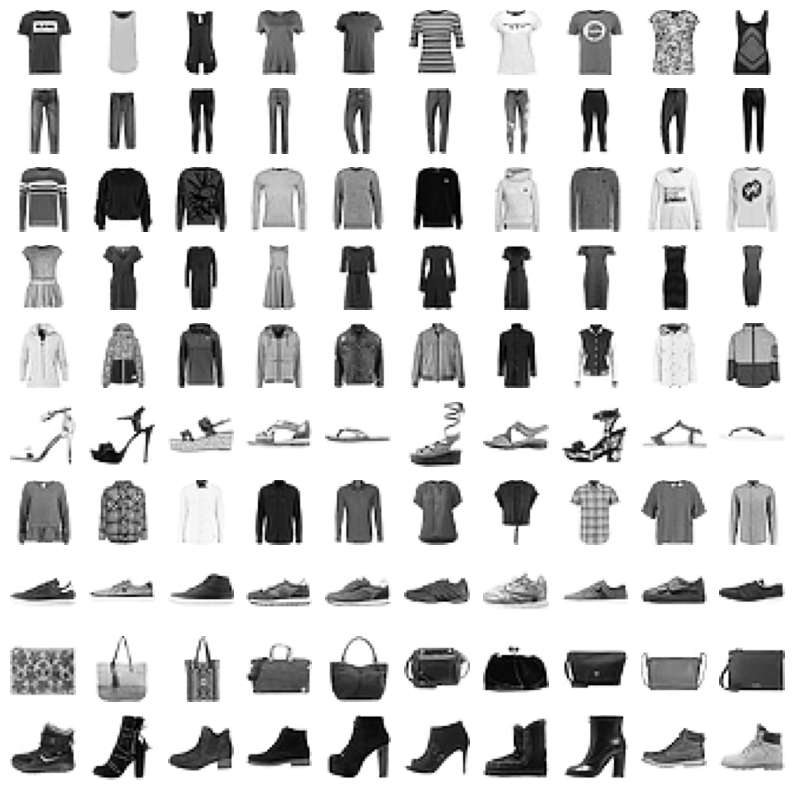

In [6]:
nrows=10
ncols=10

plt.figure(figsize=(10,10))
i = 0
for col in range(ncols):
  inds = np.where(y_train==col)[0]
  for row in range(nrows):
    plt.subplot(nrows, ncols, i+1)
    plot_image(X_train[inds[row]], cmap="Greys")
    i = i+1

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [7]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

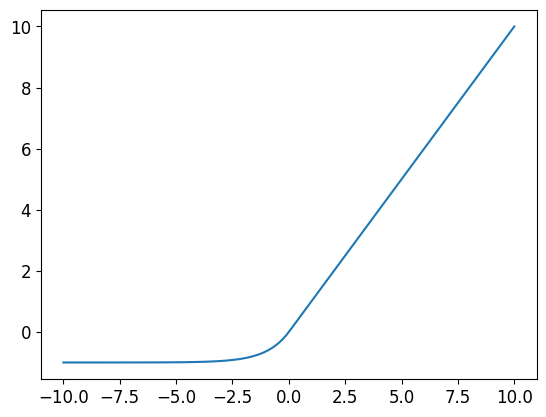

In [8]:
def selu(x, scale=1, alpha=1):
    if x > 0:
        return scale * x
    else:
      return scale * alpha * (np.exp(x) - 1)

x = np.linspace(-10,10,100)
plt.plot(x, [selu(z) for z in x]);

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(70, activation="selu"), # cuello de botella: 30
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[70]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 12s 6ms/step - loss: 0.3316 - rounded_accuracy: 0.8930 - val_loss: 0.3082 - val_rounded_accuracy: 0.9156
Epoch 2/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3013 - rounded_accuracy: 0.9192 - val_loss: 0.2982 - val_rounded_accuracy: 0.9248
Epoch 3/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2938 - rounded_accuracy: 0.9263 - val_loss: 0.2926 - val_rounded_accuracy: 0.9272
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2891 - rounded_accuracy: 0.9307 - val_loss: 0.2882 - val_rounded_accuracy: 0.9327
Epoch 5/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2860 - rounded_accuracy: 0.9337 - val_loss: 0.2861 - val_rounded_accuracy: 0.9345
Epoch 6/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2837 - rounded_accuracy: 0.9359 - val_loss: 0.2842 - val_rounded_accuracy: 0.9364
Epoch 7/20
1719/1719 [============

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 70)                85570     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            86284     
                                                                 
Total params: 171854 (671.30 KB)
Trainable params: 171854 (671.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


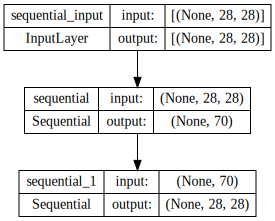

In [11]:
stacked_ae.summary()

show_model(stacked_ae)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
Total params: 85570 (334.26 KB)
Trainable params: 85570 (334.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


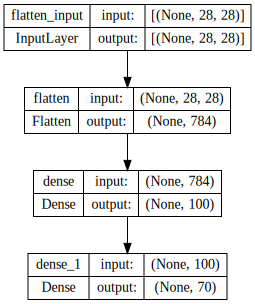

In [12]:
stacked_encoder.summary()

show_model(stacked_encoder)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               7100      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 86284 (337.05 KB)
Trainable params: 86284 (337.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


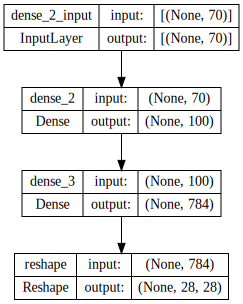

In [13]:
stacked_decoder.summary()

show_model(stacked_decoder)

In [14]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'rounded_accuracy', 'val_loss', 'val_rounded_accuracy'])


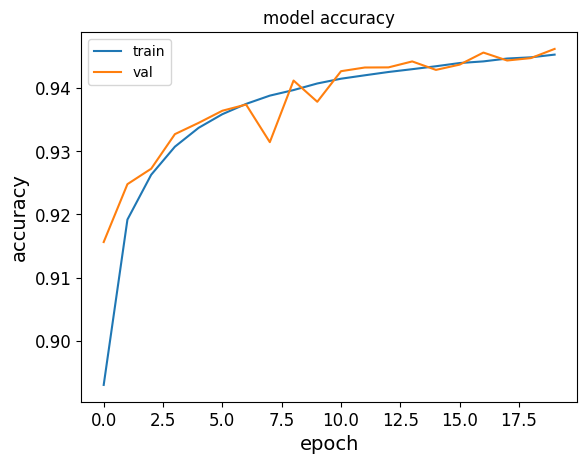

In [15]:
# summarize history for accuracy
plt.plot(history.history['rounded_accuracy'])
plt.plot(history.history['val_rounded_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

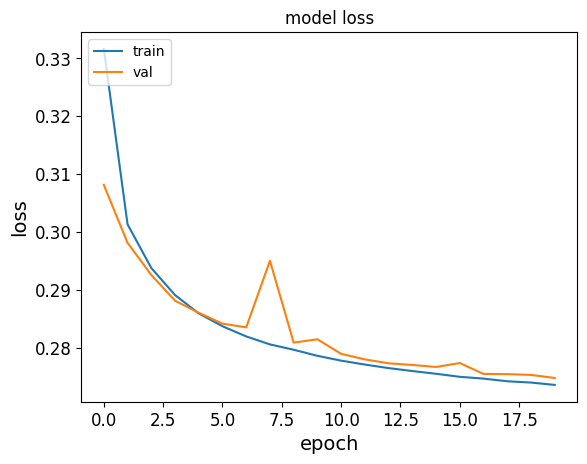

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [17]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 181ms/step


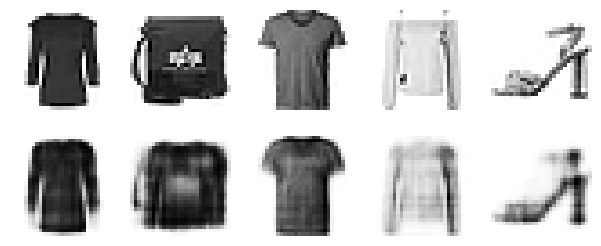

In [18]:
show_reconstructions(stacked_ae);

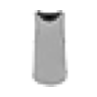

In [19]:
plt.figure(figsize=(1,1))
plot_image(X_train[2])

<Figure size 100x100 with 0 Axes>

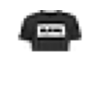

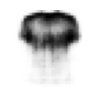

In [20]:
plt.figure(figsize=(1,1))
aux = X_train[1:2].copy()
aux[0,15:] = 0.
plt.figure(figsize=(1,1))
plot_image(aux[0])
plt.show()
plt.figure(figsize=(1,1))
plot_image(stacked_ae(aux)[0]);

<Figure size 100x100 with 0 Axes>

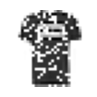

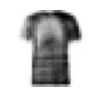

In [21]:
plt.figure(figsize=(1,1))
aux = X_train[1:2].copy()
aux = aux*(np.random.rand(aux.shape[0], aux.shape[1], aux.shape[2]) > 0.2)
plt.figure(figsize=(1,1))
plot_image(aux[0])
plt.show()
plt.figure(figsize=(1,1))
plot_image(stacked_ae(aux)[0]);

# Visualizing Fashion MNIST embeddings

In [22]:
X_valid.shape

(5000, 28, 28)

In [24]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)

X_valid_compressed.shape

157/157 [==============================] - 1s 3ms/step


(5000, 70)

In [25]:
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
np.shape(X_valid_2D)

(5000, 2)

In [26]:
print(np.shape(X_valid_2D))
print(np.shape(X_valid))

(5000, 2)
(5000, 28, 28)


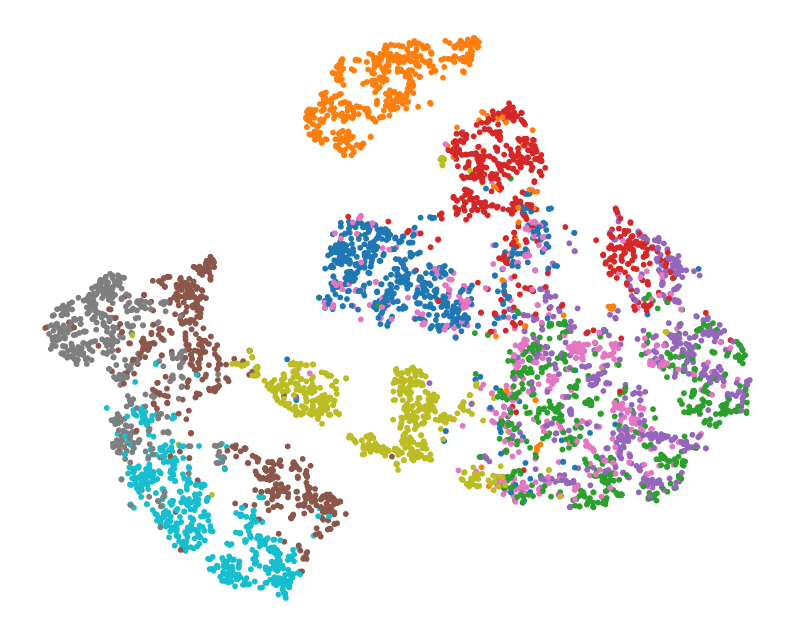

In [27]:
plt.figure(figsize=(10, 8))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off");

Let's make this diagram a bit prettier:

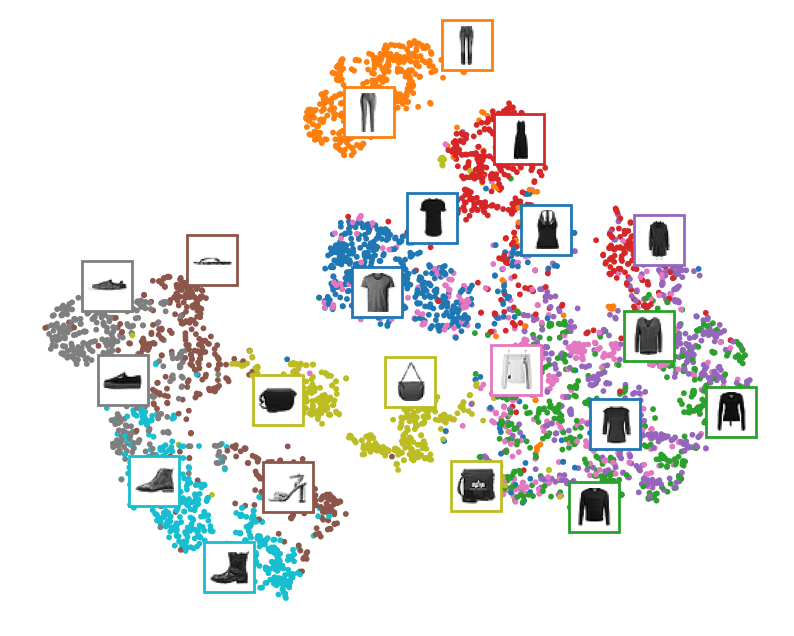

In [28]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

# Vamos a crear ropa nueva

In [29]:
cod_latente = stacked_encoder.predict(X_test[1:2])
cod_latente

1/1 [==============================] - 0s 41ms/step


array([[ 4.892378  , -1.6310812 , -1.7187574 ,  7.655346  ,  2.7229834 ,
         1.0020584 , -1.7578919 ,  0.08802092,  5.398382  , 14.680471  ,
         1.1834172 , -1.7532951 ,  3.9156246 , -1.7580234 ,  3.66311   ,
        -1.7578411 ,  3.7374854 ,  1.495579  ,  3.8103771 ,  9.484396  ,
         4.9665256 , -1.7580948 ,  1.0979946 ,  8.110622  ,  4.3609233 ,
         5.329649  ,  4.446447  , -1.7575321 ,  4.0835943 ,  8.476775  ,
        -1.7303827 ,  3.002602  , -1.756159  ,  0.5684516 , -1.7580538 ,
        -1.757902  ,  1.7906209 , -1.744015  , -1.7579101 ,  6.9920554 ,
        -1.7580966 ,  2.0431092 , -1.757737  ,  7.9133296 ,  1.6643734 ,
         3.9569185 ,  0.8682926 ,  1.2116885 , -1.4004107 , -0.56988615,
        -1.7580991 , 11.298325  , -0.8154503 ,  0.4574635 , -1.7579597 ,
        -1.7565392 ,  0.72501093, -1.6914294 , -1.7557379 ,  6.367023  ,
         2.6661327 , -1.7580668 , -1.7580584 , -0.9004334 , -1.7486376 ,
         1.5720997 ,  0.541029  , -1.5948578 ,  5.2

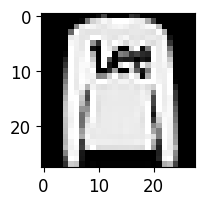

In [30]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[1], cmap="gray");

1/1 [==============================] - 0s 123ms/step


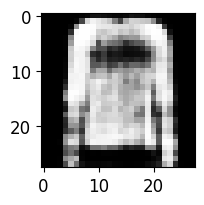

In [41]:
plt.figure(figsize=(2,2))
perturbacion = np.zeros(cod_latente.shape)
perturbacion[0,:] = 0
perturbacion = 2*np.random.randn(1,70)
plt.imshow(stacked_decoder.predict(cod_latente+perturbacion)[0], cmap="gray");

In [ ]:
perturbacion.shape